In [18]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from prophet import Prophet
from matplotlib.dates import date2num
import random
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.distribution import ZeroInflatedNegativeBinomialOutput, StudentTOutput #likelihood
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer import Trainer
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestSoftmax, SelectNBestMean

from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from gluonts.model.predictor import Predictor

latitudes = np.flipud(np.arange(65) * 0.25 + 5)
longitudes = np.arange(37) * 0.25 + 97

In [2]:
ds = xr.open_dataset("data/temp.nc")
df = ds.to_dataframe()
df.reset_index(inplace=True)
df['date'] = df['date'].dt.date
df['lat'] = [latitudes[i] for i in df['lat']]
df['lon'] = [longitudes[i] for i in df['lon']]
df['lat_lon'] = df['lat'].astype(str) + ', ' + df['lon'].astype(str)
df = df.groupby(['date', 'lat_lon'])['temp'].max().reset_index()
pivoted_df = df.pivot(index=['date'], columns='lat_lon', values='temp').reset_index()
pivoted_df = pivoted_df.set_index('date')
pivoted_df

lat_lon,"10.0, 100.0","10.0, 100.25","10.0, 100.5","10.0, 100.75","10.0, 101.0","10.0, 101.25","10.0, 101.5","10.0, 101.75","10.0, 102.0","10.0, 102.25",...,"9.75, 97.5","9.75, 97.75","9.75, 98.0","9.75, 98.25","9.75, 98.5","9.75, 98.75","9.75, 99.0","9.75, 99.25","9.75, 99.5","9.75, 99.75"
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,28.162183,28.162183,28.262183,28.362183,28.462183,28.462183,28.562183,28.562183,28.662183,28.662183,...,27.962183,27.962183,28.062183,27.962183,31.562183,31.662183,31.162183,27.862183,27.962183,27.962183
2020-01-02,28.121875,28.121875,28.221875,28.221875,28.221875,28.321875,28.521875,29.021875,29.121875,29.121875,...,27.721875,27.821875,27.821875,28.021875,31.521875,31.721875,31.021875,27.821875,27.821875,27.913818
2020-01-03,28.470313,28.670313,28.770313,28.770313,28.770313,28.770313,28.770313,28.770313,28.670313,28.670313,...,27.895728,27.795728,27.870313,28.170313,31.670313,31.370313,30.870313,28.070313,27.970313,27.970313
2020-01-04,28.396338,28.396338,28.448950,28.496338,28.496338,28.596338,28.596338,28.596338,28.548950,28.596338,...,28.048950,28.096338,28.096338,28.196338,31.996338,32.396338,31.596338,28.148950,28.196338,28.248950
2020-01-05,28.538770,28.638770,28.638770,28.638770,28.638770,28.638770,28.738770,28.938770,28.938770,28.938770,...,28.050024,27.950024,28.038770,28.138770,32.338770,32.138770,31.438770,28.238770,28.338770,28.338770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-17,29.262549,29.362549,29.462549,29.562549,29.562549,29.662549,29.762549,29.762549,29.762549,29.862549,...,29.198730,29.062549,28.962549,28.962549,28.362549,25.862549,27.162549,29.062549,29.162549,29.162549
2023-11-18,28.974292,29.074292,29.174292,29.274292,29.374292,29.471240,29.474292,29.474292,29.574292,29.574292,...,28.974292,28.874292,28.774292,28.674292,27.071240,23.871240,25.571240,28.774292,28.774292,28.874292
2023-11-19,28.909180,29.009180,29.109180,29.309180,29.409180,29.409180,29.381519,29.309180,29.187915,29.109180,...,29.009180,28.909180,28.709180,28.709180,29.909180,28.109180,28.709180,28.709180,28.809180,28.909180


In [3]:
training_list = []
for data in pivoted_df:
    training_list.append({"start": pivoted_df.index[0], "target": pivoted_df[data][:datetime.date(2023, 1, 1)].tolist()})

In [4]:
training_data = ListDataset(
    training_list,
    freq="D"
)

In [5]:
entry = next(iter(training_data))
train_series = to_pandas(entry)

In [13]:
test_list = []
for data in pivoted_df:
    test_list.append({"start": pivoted_df.index[0], "target": pivoted_df[data][:datetime.date(2023, 11, 19)].tolist()})

In [14]:
test_data = ListDataset(
    test_list,
    freq="D"
)

In [8]:
entry = next(iter(test_data))
test_series = to_pandas(entry)

In [9]:
index_train_end = pivoted_df.index.get_loc(datetime.date(2023, 1, 1))

In [16]:
test_data2 = ListDataset(
    random.sample(test_list, 20),
    freq="D"
)

In [19]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data2,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

NameError: name 'predictor' is not defined

In [21]:
forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]

In [24]:
forecast_entry

gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[25.882334, 34.390102, 17.397495, ..., 28.876749, 28.661055,
        30.54154 ],
       [26.468775, 27.479223, 28.091364, ..., 31.794552, 29.949871,
        25.727226],
       [29.182537, 26.062113, 29.295687, ..., 37.374714, 28.070194,
        28.960716],
       ...,
       [25.931114, 27.144789, 26.131456, ..., 23.459093, 28.472097,
        25.901165],
       [24.310541, 26.823292, 24.771723, ..., 27.998535, 29.509256,
        31.423342],
       [25.914843, 24.989607, 24.25021 , ..., 26.288588, 25.850855,
        27.65625 ]], dtype=float32), start_date=Period('2023-01-18', 'D'))

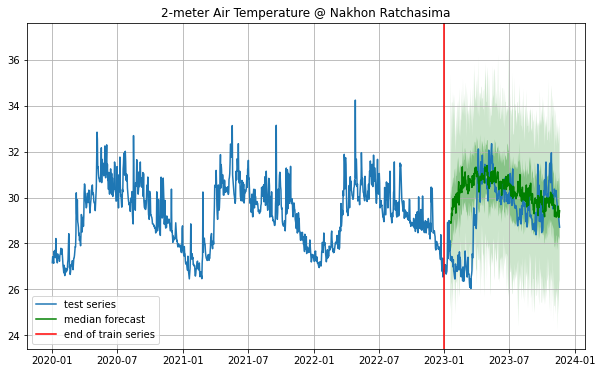

In [40]:
index = 10
plt.figure(figsize=(10, 6))
plt.plot(tss[index].to_timestamp(),label="test series")

# Assuming forecasts[index] is a gluonts.model.forecast.Forecast object
forecast_index = np.array(forecasts[index].index.to_timestamp())
forecast_values = np.array(forecasts[index].quantile(0.5))  # Convert to numpy array

plt.plot(forecast_index, forecast_values, label="median forecast", color='g')
for interval in (0.5, 0.9):
    label = interval
    low = (1 - interval) / 2
    plt.fill_between(
        forecasts[index].index.to_timestamp(),
        forecasts[index].quantile(low),
        forecasts[index].quantile(1 - low),
        alpha=0.5 - interval / 3,
        facecolor='g',
        label=None,
    )


plt.grid(which="both")
plt.axvline(pivoted_df.index[index_train_end], color='r', label="end of train series") # end of train dataset
plt.legend(loc="lower left")
plt.title('Surface Temperature @ Nakhon Ratchasima')




plt.show()

In [ ]:
index = 131
plt.figure(figsize=(10, 6))
plt.plot(tss[index].to_timestamp(),label="test series")


# Assuming forecasts[index] is a gluonts.model.forecast.Forecast object
forecast_index = np.array(forecasts[index].index.to_timestamp())
forecast_values = np.array(forecasts[index].quantile(0.5))  # Convert to numpy array

plt.plot(forecast_index, forecast_values, label="median forecast", color='g')


plt.grid(which="both")
plt.axvline(pivoted_df.index[index_train_end], color='r', label="end of train series") # end of train dataset
plt.legend(loc="lower left")
plt.title('2-meter Air Temperature @ Nakhon Ratchasima')


plt.show()

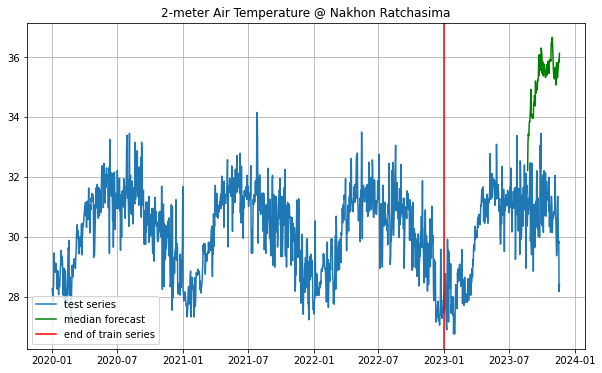

In [96]:
index = 10
plt.figure(figsize=(10, 6))
plt.plot(tss[index].to_timestamp(),label="test series")


# Assuming forecasts[index] is a gluonts.model.forecast.Forecast object
forecast_index = np.array(forecasts[index].index.to_timestamp())
forecast_values = np.array(forecasts[index].quantile(0.5))  # Convert to numpy array

plt.plot(forecast_index, forecast_values, label="median forecast", color='g')


plt.grid(which="both")
plt.axvline(pivoted_df.index[index_train_end], color='r', label="end of train series") # end of train dataset
plt.legend(loc="lower left")
plt.title('2-meter Air Temperature @ Nakhon Ratchasima')


plt.show()

In [90]:
!pip install --upgrade pandas

  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/6a/81/711b32480f508dcf29cb501f61c4f1c3c72409e9168c6625145440c1c320/pandas-2.1.3-cp310-cp310-macosx_10_9_x86_64.whl.metadata
  Using cached pandas-2.1.3-cp310-cp310-macosx_10_9_x86_64.whl.metadata (18 kB)
Using cached pandas-2.1.3-cp310-cp310-macosx_10_9_x86_64.whl (11.7 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.4
    Uninstalling pandas-1.4.4:
      Successfully uninstalled pandas-1.4.4

[notice] A new release of pip is available: 23.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
